In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Define the file path
file_path = '../data/hurdat2_1851_2023.txt'

In [8]:
# Initialize variables
cyclone_data = []
current_cyclone = None

# Function to convert latitude and longitude to float
def convert_lat_lon(value):
    if 'N' in value or 'E' in value:
        return float(value[:-1])
    elif 'S' in value or 'W' in value:
        return -float(value[:-1])

# Read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Check if the line starts with 'AL' indicating a new cyclone
        if line.startswith('AL'):
            if current_cyclone is not None:
                cyclone_data.append(current_cyclone)
            current_cyclone = {'header': line.strip(), 'data': []}
        else:
            if current_cyclone is not None:
                current_cyclone['data'].append(line.strip().split(','))

# Append the last cyclone
if current_cyclone is not None:
    cyclone_data.append(current_cyclone)

# Process each cyclone's data
all_cyclone_dfs = []
for cyclone in cyclone_data:
    df = pd.DataFrame(cyclone['data'], columns=['Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude', 'WindSpeed', 'Pressure',
                                                'Rad_34_NE', 'Rad_34_SE', 'Rad_34_SW', 'Rad_34_NW', 'Rad_50_NE', 'Rad_50_SE',
                                                'Rad_50_SW', 'Rad_50_NW', 'Rad_64_NE', 'Rad_64_SE', 'Rad_64_SW', 'Rad_64_NW', 'maxwnd'])
    # Convert data types where necessary
    df['Date'] = df['Date'].astype(str)
    df['Time'] = df['Time'].astype(str)
    df['Latitude'] = df['Latitude'].apply(convert_lat_lon)
    df['Longitude'] = df['Longitude'].apply(convert_lat_lon)
    df['WindSpeed'] = df['WindSpeed'].astype(int)
    df['Pressure'] = df['Pressure'].astype(int)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y%m%d %H%M')
    df.set_index('Datetime', inplace=True)
    df['Cyclone'] = cyclone['header']  # Add a column for the cyclone identifier
    all_cyclone_dfs.append(df)

# Concatenate all cyclone dataframes into a single dataframe
all_data = pd.concat(all_cyclone_dfs)

# Move the Cyclone column to the first position
columns = ['Cyclone'] + [col for col in all_data.columns if col != 'Cyclone']
all_data = all_data[columns]

# Define the latitude and longitude range for filtering
min_lat, max_lat = 27.5, 29.4
min_lon, max_lon = -81.5, -78.8

# Filter the data based on the specified latitude and longitude range
filtered_data = all_data[(all_data['Latitude'] >= min_lat) & (all_data['Latitude'] <= max_lat) &
                         (all_data['Longitude'] >= min_lon) & (all_data['Longitude'] <= max_lon)]

# Define the priority order for statuses
priority_order = {'HU': 1, 'TS': 2, 'TD': 3}
filtered_data['StatusPriority'] = filtered_data['Status'].map(priority_order).fillna(4)

# Extract the year from the Datetime column
filtered_data['Year'] = filtered_data.index.year

# Group by year and count unique cyclones
cyclones_per_year = filtered_data.groupby('Year')['Cyclone'].nunique()




/var/folders/hz/sg34vg_92b77c_hdxw3wkl400000gn/T/ipykernel_15002/797672786.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['StatusPriority'] = filtered_data['Status'].map(priority_order).fillna(4)
/var/folders/hz/sg34vg_92b77c_hdxw3wkl400000gn/T/ipykernel_15002/797672786.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data.index.year


In [ ]:
# Define the priority order for statuses
#new_all_data = all_data['StatusPriority'] = all_data['Status'].map(priority_order).fillna(4)
#new_all_data = all_data.sort_values(by=['Cyclone', 'StatusPriority'], inplace=True)

In [9]:
# Extract the first entry for each cyclone based on priority
greatest_status_per_cyclone = filtered_data.groupby('Cyclone').first().reset_index()

In [12]:
aoi_status_counts = greatest_status_per_cyclone['Status'].value_counts()

In [20]:
aoi_status_counts

Status
 TS    56
 HU    35
 TD    31
 SD     4
 EX     3
 SS     2
 LO     1
Name: count, dtype: int64

In [ ]:
# Calculate the trend line
z = np.polyfit(cyclones_per_year.index, cyclones_per_year.values, 2)
p = np.poly1d(z)

# Define the future range for forecasting
last_year = cyclones_per_year.index.max()
future_years = np.arange(last_year + 1, last_year + 27)

# Combine the historical and future years
extended_years = np.concatenate((cyclones_per_year.index, future_years))

# Calculate the trendline values for the extended range
trendline_values = p(extended_years)

In [ ]:
all_years = pd.Series(0, index=np.arange(filtered_data['Year'].min(), filtered_data['Year'].max() + 1))

# Reindex the cyclones_per_year series to include all years
cyclones_per_year = cyclones_per_year.reindex(all_years.index, fill_value=0)

# Calculate the trend line
z = np.polyfit(cyclones_per_year.index, cyclones_per_year.values, 2)
p = np.poly1d(z)

# Define the future range for forecasting
last_year = cyclones_per_year.index.max()
future_years = np.arange(last_year + 1, last_year + 27)

# Combine the historical and future years
extended_years = np.concatenate((cyclones_per_year.index, future_years))

# Calculate the trendline values for the extended range
trendline_values = p(extended_years)



In [ ]:
# Plot the total number of cyclones per year with extended trend line
plt.figure(figsize=(10, 6))
plt.plot(cyclones_per_year.index, cyclones_per_year.values, marker='o', markersize=2, drawstyle='steps', label='Number of Cyclones')
plt.plot(extended_years, trendline_values, "r--", label='Trend Line')
plt.title('Total Number of Cyclones per Year with Forecast (Filtered by Lat/Lon)')
plt.xlabel('Year')
plt.ylabel('Number of Cyclones')
plt.ylim(bottom=0)  # Set y-axis to start at 0
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
smoothed_data = cyclones_per_year.rolling(window=5).mean()

plt.figure(figsize=(12, 6))
#plt.plot(cyclones_per_year.index, cyclones_per_year.values, 'o', markersize=2, label='Number of Cyclones')
plt.plot(smoothed_data.index, smoothed_data.values, label='Smoothed Number of Cyclones')
plt.plot(extended_years, trendline_values, "r--", label='Trend Line')
plt.title('Total Number of Cyclones per Year with Forecast for AOI')
plt.xlabel('Year')
plt.ylabel('Number of Cyclones')
plt.ylim(bottom=0)  # Set y-axis to start at 0
plt.legend()
plt.grid(True)
plt.show()

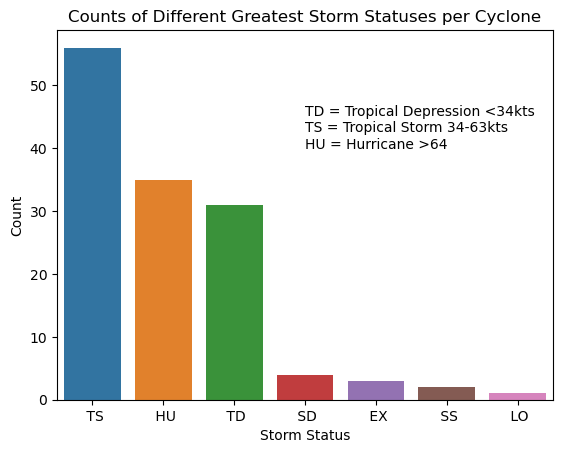

In [28]:
fig, ax = plt.subplots()
sns.barplot(x=aoi_status_counts.index, y=aoi_status_counts)
plt.title('Counts of Different Greatest Storm Statuses per Cyclone')
plt.xlabel('Storm Status')
plt.ylabel('Count')
plt.text(3, 40, 'TD = Tropical Depression <34kts\nTS = Tropical Storm 34-63kts\nHU = Hurricane >64')
plt.show()